In [4]:
import sys
sys.path.insert(0, "/home/sanj/projects/gaardian/workflow/scripts/")
import probetools as probe

In [5]:
import malariagen_data
import numpy as np
import pandas as pd

### Creating synthetic relatives to test KING with

- Need to sample across whole genome - recombination breaks should be calculated across chromosomal arms (2l+2r), however, we cannot phase across chromosomal arm boundaries... can we?? and does this matter?
- What to do with the X?
- Do we need a female parent and a male parent?
- Are the X's haploid / homozygous in ag1000g males?

In [6]:
ag3 = malariagen_data.Ag3()

In [7]:
cohort = 'AG1000G-GH'

In [65]:
snps = ag3.haplotypes(region='2R', sample_sets=cohort, analysis='gamb_colu')

In [66]:
pos = ag3.snp_sites('2R', 'POS').compute()

In [67]:
meta = ag3.sample_metadata(cohort)

In [ ]:
meta = snps['sample_id']

In [73]:
parents = snps['call_genotype'][:,:2, :].compute()

In [227]:
def get_recomb_breakpoints(pos, recomb_rate):
    end = pos[-1]
    arr = np.random.binomial(1, p=10**-8, size=end)
    if arr.sum() > 0:
        idx = np.where(arr)[0]
        print(f"there are {arr.sum()} recombinations")
    else:
        print(f"there are 0 recombinations")
        idx = []
    
    return(idx)

In [249]:
def concat_haplotypes(breaks, parents, parent_idx, end):
    parent_chromosome = np.random.randint(2)
    
    if len(breaks) == 0:
        haplo1 = parents[:, parent_idx, parent_chromosome].values
    else:
        haplo1 = np.array([])
        newbreaks = np.concatenate([[0], breaks, [end]])
        breaks = np.concatenate([breaks, [end]])
        for idx, breaks in enumerate(breaks):
            if (idx % 2) == 1:
                parent_chromosome = 1 if parent_chromosome == 0 else 0
            hap = parents[newbreaks[idx]:newbreaks[idx+1], parent_idx, parent_chromosome].values
            haplo1 = np.concatenate([haplo1, hap])
    return(haplo1)

In [250]:
def sample_parents_haplotypes(parents, pos, recomb_rate):

    breaks = get_recomb_breakpoints(pos, recomb_rate)
    parent_idx = 0
    parent1hap = concat_haplotypes(breaks, parents, parent_idx, pos[-1])
    print(parent1hap.shape)
        
    breaks = get_recomb_breakpoints(pos, recomb_rate)
    parent_idx = 1
    parent2hap = concat_haplotypes(breaks, parents, parent_idx, pos[-1])
    print(parent2hap.shape)
    
    offspring_genotypes = allel.GenotypeVector(np.stack([parent1hap, parent2hap], axis=1).astype('i'))
    
    return(offspring_genotypes)

In [251]:
geno_sis = sample_parents_haplotypes(parents, pos, 10**-8)

there are 1 recombinations
(17907839,)
there are 1 recombinations
(17907839,)


In [252]:
geno_bro = sample_parents_haplotypes(parents, pos, 10**-8)

there are 2 recombinations
(17907839,)
there are 1 recombinations
(17907839,)


In [270]:
ac_bro = geno_bro.to_haplotypes().count_alleles()
ac_sis = geno_sis.to_haplotypes().count_alleles()

In [276]:
ac_sis.shape

(17907839, 2)

In [275]:
ac_bro.shape

(17907839, 2)

In [281]:
pos = snps['variant_position']

In [306]:
fst, window_spans, nSNPs, =  allel.windowed_hudson_fst(pos.values, ac_bro, ac_sis, size=1000000)

In [307]:
?allel.windowed_hudson_fst

In [309]:
midpoints = np.apply_along_axis(func1d=np.median, axis=1, arr=window_spans)

In [310]:
import seaborn as sns

<AxesSubplot:>

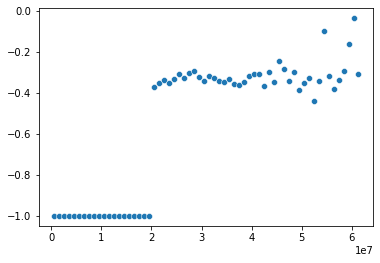

In [312]:
sns.scatterplot(x=midpoints, y=fst)